In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Load Data
train = pd.read_csv("/content/drive/MyDrive/7788/data/Train_data.csv")
test = pd.read_csv("/content/drive/MyDrive/7788/data/Test_data.csv")

print(train.head(4))

print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

print(test.head(4))

print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0             

In [3]:
#Exploratory Analysis
# Descriptive statistics
train.describe()

print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

# Attack  Distribution
train['class'].value_counts()


num_outbound_cmds
0    25192
Name: count, dtype: int64
num_outbound_cmds
0    22544
Name: count, dtype: int64


class
normal     13449
anomaly    11743
Name: count, dtype: int64

In [4]:
#Scalling numerical attributes
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [5]:
#Encoding categorical attributes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [6]:
#Union of processed numerical and categorical data
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = cat_Ytrain
train_x.shape

test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

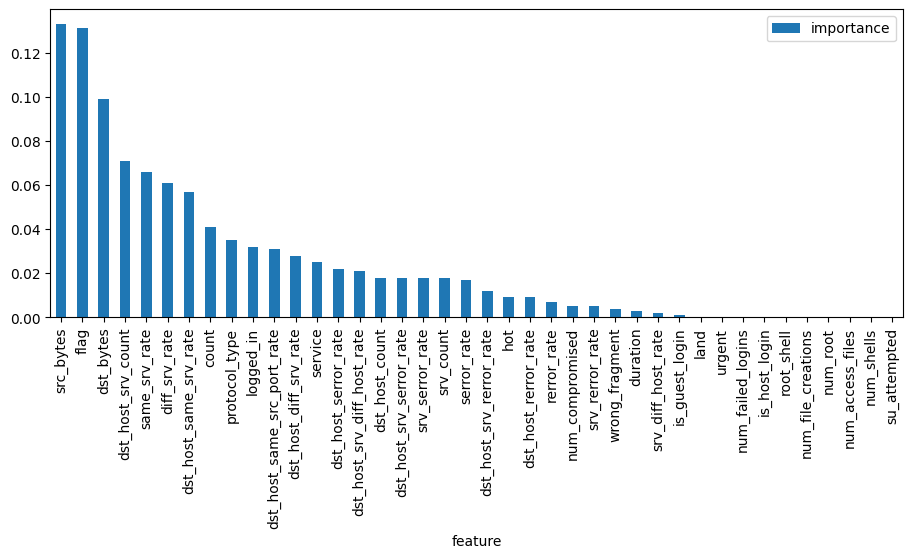

In [7]:
#Feature Selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest on the training set
rfc.fit(train_x, train_y);

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [8]:
#Recursive feature elimination
from sklearn.feature_selection import RFE
import itertools

rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

In [9]:
a = [i[0] for i in feature_map]

train_x = train_x.iloc[:,a]
test_df = test_df.iloc[:,a]

**Divide in test and Training**

In [10]:
#Dataset Partition
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)

#Fitting Models
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))

# Adding the second hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
history = classifier.fit(X_train, Y_train, batch_size = 10, epochs = 10)

Epoch 1/10
1764/1764 [==============================] - 9s 3ms/step - loss: 0.2468 - accuracy: 0.9079
Epoch 2/10
1764/1764 [==============================] - 7s 4ms/step - loss: 0.1655 - accuracy: 0.9381
Epoch 3/10
1764/1764 [==============================] - 7s 4ms/step - loss: 0.1505 - accuracy: 0.9453
Epoch 4/10
1764/1764 [==============================] - 6s 4ms/step - loss: 0.1439 - accuracy: 0.9481
Epoch 5/10
1764/1764 [==============================] - 7s 4ms/step - loss: 0.1381 - accuracy: 0.9518
Epoch 6/10
1764/1764 [==============================] - 6s 3ms/step - loss: 0.1339 - accuracy: 0.9538
Epoch 7/10
1764/1764 [==============================] - 9s 5ms/step - loss: 0.1292 - accuracy: 0.9572
Epoch 8/10
1764/1764 [==============================] - 9s 5ms/step - loss: 0.1261 - accuracy: 0.9575
Epoch 9/10
1764/1764 [==============================] - 7s 4ms/step - loss: 0.1220 - accuracy: 0.9591
Epoch 10/10
1764/1764 [==============================] - 6s 3ms/step - loss: 0.119

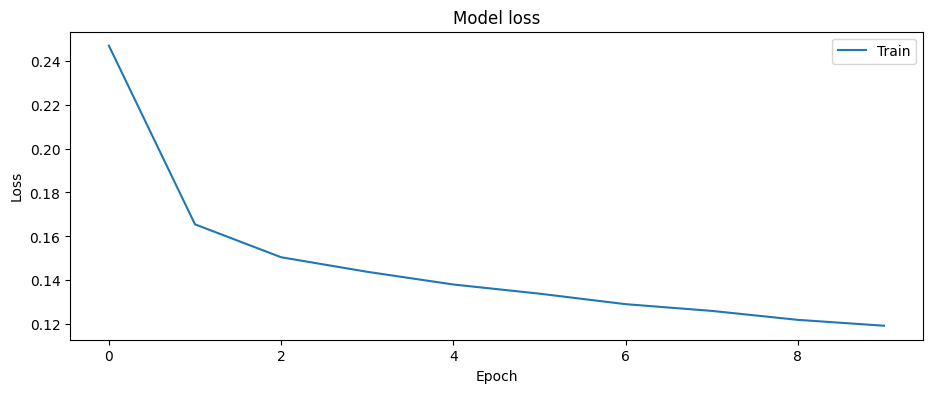

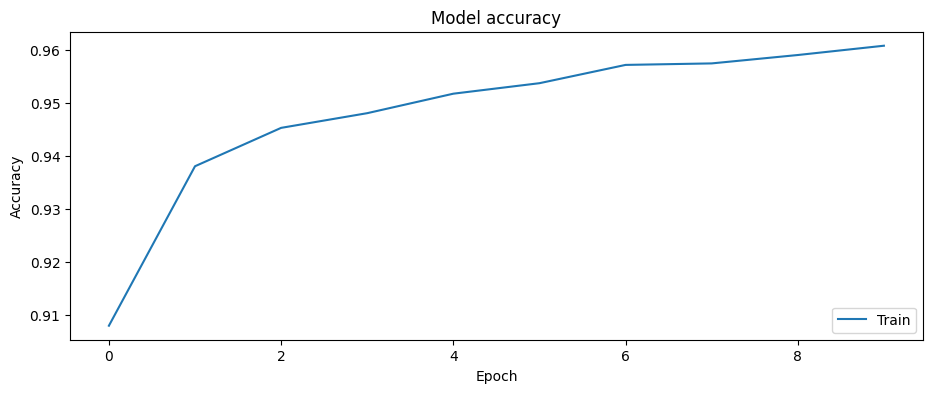

In [11]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [12]:
yhat_train = (classifier.predict(X_train) > 0.5)
yhat_test = (classifier.predict(X_test) > 0.5)

237/237 [==============================] - 0s 2ms/step


In [13]:
# PREDICTING FOR TEST DATA
pred_ann = classifier.predict(test_df)

705/705 [==============================] - 1s 2ms/step


In [14]:
# pip install keras==2.12.0

In [15]:
#Evaluate Models
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 10)

scores = cross_val_score(estimator = classifier,X = X_train, y = Y_train, cv = 2, n_jobs = 1)

ModuleNotFoundError: No module named 'keras.wrappers'

In [ ]:
accuracy = metrics.accuracy_score(Y_train, yhat_train)
confusion_matrix = metrics.confusion_matrix(Y_train, yhat_train)
classification = metrics.classification_report(Y_train, yhat_train)
print()
print('============================== ANN Model Evaluation ==============================' )
print()
print ("Cross Validation Mean Score:" "\n", scores.mean())
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("report:" "\n", classification)
print()

In [ ]:
#Validate Models
accuracy = metrics.accuracy_score(Y_test, yhat_test)
confusion_matrix = metrics.confusion_matrix(Y_test, yhat_test)
classification = metrics.classification_report(Y_test, yhat_test)
print()
print('============================== ANN Model Test Results ==============================')
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("report:" "\n", classification)
print()

#GaussianNB

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize the Naive Bayes classifier
naive_bayes = GaussianNB()

# Train the Naive Bayes model on the training data
naive_bayes.fit(X_train, Y_train)

# Predict the labels for the test data
y_pred = naive_bayes.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

# Print report
print("Report:")
print(classification_report(Y_test, y_pred))

# Calculate and plot confusion matrix
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
